---

$$ Capstone \ Project $$
=


# $$ Predictive\ Modeling\ of\ Movie\ Success $$


---

In [3]:
# Import library 

import ast
from datetime import datetime as dt


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats


from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, mean_squared_error, precision_score
from sklearn.metrics import r2_score, recall_score, roc_auc_score

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


---

In [5]:
tmd = pd.read_csv("tmdb_movies.csv")
tm5 = pd.read_csv("tmdb_5000_movies.csv")
tc5 = pd.read_csv("tmdb_5000_credits.csv")

In [ ]:
tmd.head(3)

In [ ]:
tm5.head(3)

In [ ]:
tc5.head(3)

# Data Before Pre-Processing

In [9]:
print("Data before preprocessing for 'tmdb_movies.csv'")

print("-"*100)
print(tmd.info())
print("-"*100)
print(tmd.isnull().sum())
print("-"*100)


Data before preprocessing for 'tmdb_movies.csv'
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4799 non-null   int64  
 1   genres                4799 non-null   object 
 2   id                    4799 non-null   int64  
 3   original_language     4799 non-null   object 
 4   popularity            4799 non-null   float64
 5   production_companies  4450 non-null   object 
 6   production_countries  4627 non-null   object 
 7   release_date          4799 non-null   object 
 8   revenue               4799 non-null   int64  
 9   runtime               4799 non-null   int64  
 10  status                4799 non-null   object 
 11  vote_average          4799 non-null   float64
 12  vote_count            479

In [11]:
print("Data before preprocessing for 'tmdb_5000_movies.csv'")

print("-"*100)
print(tm5.info())
print("-"*100)
print(tm5.isnull().sum())
print("-"*100)


Data before preprocessing for 'tmdb_5000_movies.csv'
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   production_countries  4803 non-null   object 
 10  release_date          4802 non-null   object 
 11  revenue               4803 non-null   int64  
 12  runtime             

In [13]:
print("Data before preprocessing for 'tmdb_5000_credits.csv'")

print("-"*100)
print(tc5.info())
print("-"*100)
print(tc5.isnull().sum())
print("-"*100)


Data before preprocessing for 'tmdb_5000_credits.csv'
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB
None
----------------------------------------------------------------------------------------------------
movie_id    0
title       0
cast        0
crew        0
dtype: int64
----------------------------------------------------------------------------------------------------


# Data Pre-Processing

In [7]:
# --------------------------------------------------------------------------------------------------------

# to Convert the object format to date and time format for the release date column.
tmd['release_date'] = pd.to_datetime(tmd['release_date'], format = '%d-%m-%Y')

# To replace empty cells with the median or drop rows with empty cells.
tmd['production_companies'] = tmd['production_companies'].fillna(tmd['production_companies'].median)
tmd['production_countries'] = tmd['production_countries'].fillna(tmd['production_countries'].median)
tmd['director'] = tmd['director'].fillna(tmd['director'].median)

expm = tmd.drop(
    columns=[
        'budget',
        'original_language',
        'popularity',
        'release_date',
        'revenue',
        'runtime',
        'status',
        'vote_average',
        'vote_count'])

# --------------------------------------------------------------------------------------------------------

# to Convert the object format to date and time format for the release date column.
tm5['release_date'] = pd.to_datetime(tm5['release_date'], format = '%d-%m-%Y')

# To replace empty cells with the median or drop rows with empty cells.
tm5['release_date'] = tm5['release_date'].fillna(tm5['release_date'].median)
tm5['runtime'] = tm5['runtime'].fillna(tm5['runtime'].median)

expm5 = tm5.drop(
    columns = [
        'genres',
        'homepage',
        'keywords',
        'overview',
        'production_companies',
        'production_countries',
        'tagline'])

# --------------------------------------------------------------------------------------------------------

expc5 = tc5.drop(columns = ['cast', 'crew'])

# --------------------------------------------------------------------------------------------------------


In [ ]:
tmd.describe()

In [ ]:
tm5.describe()

In [ ]:
tc5.describe()

---

## Merge

In [9]:
merged_df = pd.merge(expm, expm5, on='id')

In [ ]:
merged_df.head()

In [57]:
merged_df.to_excel('tmdb.xlsx', index=False)

In [13]:
df = merged_df.copy()
#df.head(4)

In [15]:
def safe_literal_eval(x):
    return ast.literal_eval(x) if isinstance(x, str) else x
    

# Feature engineering
df['crew_size'] = df['actors'].apply(lambda x: len(x) if isinstance(x, list) else 1)
df['num_genres'] = df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 1)
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
df['release_month'] = pd.to_datetime(df['release_date'], errors='coerce').dt.month
df['is_US'] = df['production_countries'].apply(lambda x: 1 if isinstance(x, list) and 'United States of America' in x else 0)
df['main_genre'] = df['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')

df['genres'] = df['genres'].apply(safe_literal_eval)
df['main_genre'] = df['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')
df = df.dropna(subset=['vote_average', 'revenue', 'budget'])

# Feature engineering
df['log_revenue'] = np.log1p(df['revenue'])
df['log_budget'] = np.log1p(df['budget'])
df['high_rating'] = (df['vote_average'] >= df['vote_average'].median()).astype(int)

---

---

# **1. Advanced Reporting and Insight Generation using SQL & Excel**



## **Business Objective 1.1: Extract deeper insights using advanced SQL operations**
---
1. How can SQL window functions be used to identify the top 5 movies per runtime based on `vote_average` or `revenue`?

2. Which movies exhibit the highest and lowest profits, budgets, and revenues, and how do these distributions look across genres?
---

## **Business Objective 1.2: Develop interactive dashboards and trend visualizations using Excel**
---
1. What Excel graphs can be used to visually represent vote average, revenue, and popularity across time?

2. How can Excel dashboards be built to allow interactive filtering (e.g., by director, genre, year) to dynamically explore movie performance metrics?
---


# **2. Exploratory Data Analysis & Visualization**


## **Business Objective 2.1: Uncover temporal and financial trends**
---
  1. Which release years and months show the highest count of movie releases?

  2. Which movies exhibit the highest and lowest profits, budgets, and revenues, and how do these distributions look across genres?
---
## **Business Objective 2.2: Understand audience engagement metrics**
---
  1. Which movies have the highest and lowest vote counts, and how are these votes correlated with revenue and popularity?

  2. How do vote averages distribute—do they follow a normal distribution, or are they skewed by blockbuster hits?
---


# **3. Understanding Audience Engagement and Production Company Contributions**


---

## **Business Objective 3.1: Assess audience voting patterns and distributions**
---
1. What is the distribution of `vote_average` scores, and are there particular ranges that are most common or least common?

2. How does the total `Voter Counts` distribution look, and are there specific `vote_average` bins that attract significantly more votes?
---

## **Business Objective 3.2: Identify key contributors and their market share in movie production**
---
1. Which production companies have produced the highest number of movies, and what is their proportional share of the total movie output?

2. How do `vote_average` scores and `production_companies` contribute to the overall distribution of movies, and are there certain companies associated with higher average ratings?
---


# **4. Statistical Analysis & Hypothesis Testing**

---

## **Business Objective 4.1: Quantify performance differences based on movie characteristics**

---
1. What is the conditional probability that a movie with a budget exceeding $\$150$ million will earn over $\$500$ million in revenue?

---

\begin{equation}
    P(A|B) = \frac{P(A \cap B)}{P(B)}
\end{equation}


In [77]:
b150m = df['budget'] > 150000000
s500m = df['revenue'] > 500000000

conditional_probability = (df[b150m & s500m].shape[0] / df[b150m].shape[0])

print(f"Conditional Probability % : {(round(conditional_probability,4))*100}%")

Conditional Probability % : 56.31%


---

### 2. Is there a significant difference in average revenue between movies directed by top 10 directors (by `vote_average`) versus other directors?

---



**Null Hypothesis ($H_0$)**: There is **no significant difference** in the average revenue between movies directed by the top 10 directors (by `vote_average`) and movies directed by other directors.


**Alternative Hypothesis ($H_a$)**: There **is a significant difference** in the average revenue between movies directed by the top 10 directors and movies directed by other directors.



In [97]:

# Get top 10 directors by average vote_average
top_directors = df.groupby('director')['vote_average'].mean().nlargest(10).index

# Separate revenues. Standardized to use 'df' consistently.
top_director_revenue = df[df['director'].isin(top_directors)]['revenue']
other_director_revenue = df[~df['director'].isin(top_directors)]['revenue']


# Independent t-test (Welch's t-test)
t_stat, p_value = stats.ttest_ind(top_director_revenue, other_director_revenue, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, \np-value    :  {p_value:.3f}\n")

print("-" * 50)

# A small p-value (< 0.05) means we REJECT the null hypothesis.
if p_value < 0.05:
    print("Rejected the null hypothesis: \nThere is a significant difference in average revenue.")
else:
    # A larger p-value means we FAIL to reject the null hypothesis.
    print("Fail to reject the null hypothesis: \nThere is no significant difference in average revenue.")


T-statistic: -30.572, 
p-value    :  0.000

--------------------------------------------------
Rejected the null hypothesis: 
There is a significant difference in average revenue.


---

## **Business Objective 4.2: Validate overall budget and rating assumptions**

---

1. Does the mean movie budget differ significantly from $\$100$ million at a $5\%$ significance level?

---


**Null Hypothesis ($H_0$)**: The mean movie budget is equal to $\$100$

**Alternative Hypothesis ($H_a$)**: The mean movie budget does differ significantly from $\$100$



In [93]:

mu = df['budget'].mean()
std = df['budget'].std()
alpha = 0.05     

sample = merged_df['budget'].sample(n=1000, random_state=42)
sample_mean = sample.mean()

z_stat = (sample_mean - mu) / (std / np.sqrt(40))
p_value = 1 - stats.norm.cdf(z_stat)


print(f"Sample Mean : {sample_mean:.2f}")
print(f"Z-Statistic : {z_stat:.4f}")
print(f"P-Value     : {p_value:.4f}")

print("\n")
print("-"*50)

if p_value < alpha:
    print("Conclusion: Reject the null hypothesis. \nThe mean movie budget does differ significantly from $100")
else:
    print("Conclusion: Fail to reject the null hypothesis. \nThe mean movie budget is equal to $100")


Sample Mean : 31520991.81
Z-Statistic : 0.3812
P-Value     : 0.3515


--------------------------------------------------
Conclusion: Fail to reject the null hypothesis. 
The mean movie budget is equal to $100


---

2. Do vote averages follow a normal distribution? If not, what non-parametric tests are appropriate?

---

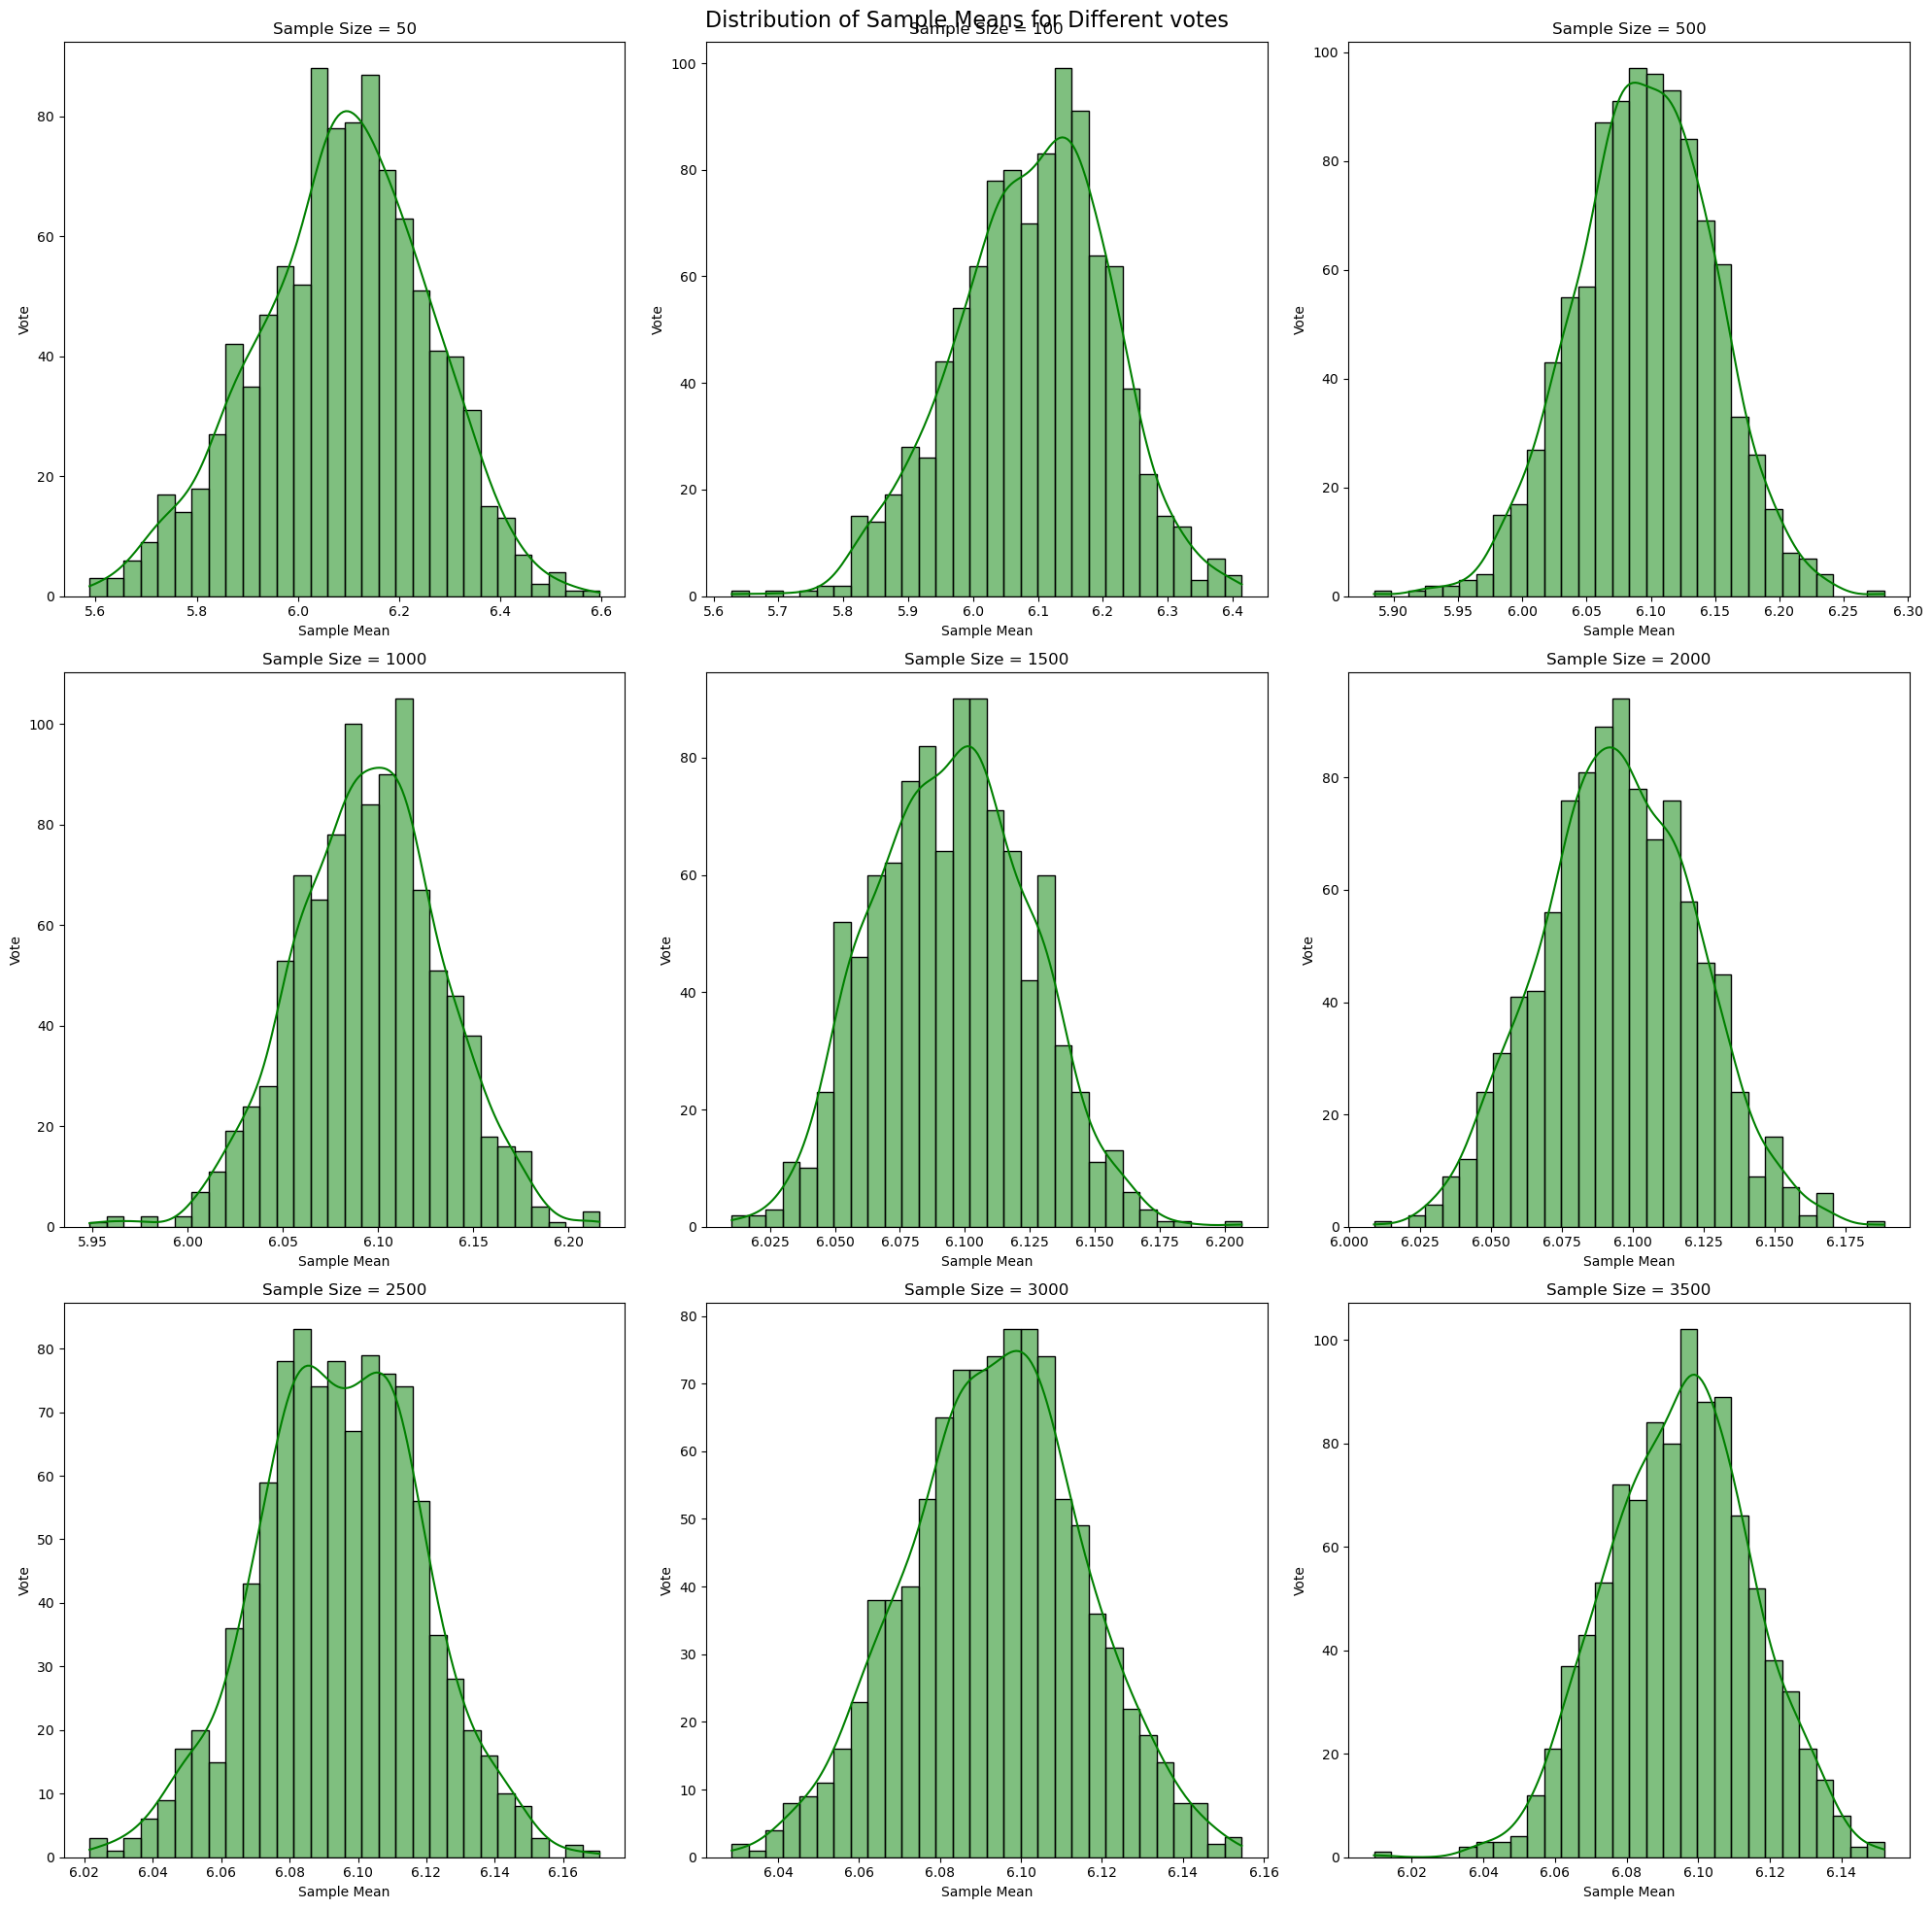

In [101]:
sample_sizes = [50,100,500,1000,1500,2000,2500,3000,3500]
sample_means_dict = {}

for size in sample_sizes:
    means = [df['vote_average'].sample(n=size, replace=True).mean() for _ in range(1000)]
    sample_means_dict[size] = means

plt.figure(figsize=(20, 20))
for i, size in enumerate(sample_sizes):
    plt.subplot(3, 3, i+1)
    sns.histplot(sample_means_dict[size], kde=True, bins=30, color='green')
    plt.title(f"Sample Size = {size}")
    plt.xlabel("Sample Mean")
    plt.ylabel("Vote")
plt.suptitle("Distribution of Sample Means for Different votes", fontsize=16)
plt.tight_layout()
plt.show()

#plt.savefig('C:/Users/Neelesh/Z Python/Capstone Project/Distribution of Sample Means for Different votes.png', format='png')

---

# **5. Predictive Modeling & Insight-Driven Decision Making**

---

## **Business Objective 5.1: Build and optimize predictive models for movie success**

---
1. Which engineered features (e.g. encoded genres, scaled budget, crew size) contribute most to predicting a movie’s rating and revenue?

---

In [42]:

# Feature definitions
features_reg = ['budget', 'crew_size', 'num_genres', 'popularity', 'runtime', 'release_year', 'is_US']
features_class = features_reg + ['main_genre']
target_revenue = 'revenue'
target_rating = 'vote_average'

# Binarize ratings for classification
rating_threshold = df[target_rating].median()
df['high_rating'] = (df[target_rating] >= rating_threshold).astype(int)

# Preprocessing for regression (numerical only)
preprocessor_reg = ColumnTransformer(
    transformers=[('num', StandardScaler(), features_reg)]
)

# Preprocessing for classification (numerical + categorical)
preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['main_genre'])
    ]
)

#  Revenue Prediction using Multiple Linear Regression 
X_rev = df[features_reg]
y_rev = df[target_revenue]
X_rev_train, X_rev_test, y_rev_train, y_rev_test = train_test_split(X_rev, y_rev, test_size=0.2, random_state=42)

reg_model = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])
reg_model.fit(X_rev_train, y_rev_train)

#  Rating Classification using Logistic Regression 
X_rat = df[features_class]
y_rat = df['high_rating']
X_rat_train, X_rat_test, y_rat_train, y_rat_test = train_test_split(X_rat, y_rat, test_size=0.2, random_state=42)

clf_model = Pipeline([
    ('preprocessor', preprocessor_class),
    ('classifier', LogisticRegression(max_iter=1000))
])
clf_model.fit(X_rat_train, y_rat_train)

#  Get feature names 
num_features = features_reg
cat_features = clf_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['main_genre'])
all_features = num_features + list(cat_features)

#  Get coefficients as feature importance 
rev_coefs = pd.Series(
    reg_model.named_steps['regressor'].coef_,
    index=num_features
)

rat_coefs = pd.Series(
    clf_model.named_steps['classifier'].coef_[0],
    index=all_features
)


In [44]:

#  Display top features 
print("Top Revenue Predictors (by coefficient magnitude):")
print(rev_coefs.abs().sort_values(ascending=False).head())

print("-" * 50)

print("Top Rating Predictors (by coefficient magnitude):")
print(rat_coefs.abs().sort_values(ascending=False).head())


Top Revenue Predictors (by coefficient magnitude):
budget          8.541961e+07
popularity      6.377151e+07
release_year    7.077577e+06
runtime         1.674639e+06
crew_size       6.705523e-08
dtype: float64
--------------------------------------------------
Top Rating Predictors (by coefficient magnitude):
popularity                1.728712
main_genre_Horror         1.346714
main_genre_Documentary    1.273059
main_genre_TV Movie       0.998061
main_genre_Foreign        0.970779
dtype: float64


---

2. Which machine learning algorithms yield the highest accuracy or lowest RMSE for classifying movie ratings and predicting revenue?

---

In [33]:

# Common features
features = ['log_budget', 'popularity', 'runtime']
target_reg = 'log_revenue'
target_class = 'high_rating'

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['main_genre'])
    ])


In [39]:

print("Algorithm Performance Comparison \n\n")



X_reg = df[features + ['main_genre']]
y_reg = df[target_reg]
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

# 1. Simple Linear Regression (only using budget)
print("1. Simple Linear Regression (Budget only)")
simple_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
simple_lr.fit(X_reg_train[['log_budget']], y_reg_train)
y_pred = simple_lr.predict(X_reg_test[['log_budget']])
print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_reg_test, y_pred):.4f}")

print("-" * 50)

# 2. Multiple Linear Regression
print("2. Multiple Linear Regression")
multi_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
multi_lr.fit(X_reg_train, y_reg_train)
y_pred = multi_lr.predict(X_reg_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_reg_test, y_pred):.4f}")



Algorithm Performance Comparison 


1. Simple Linear Regression (Budget only)
RMSE: 5.6813
R²: 0.5110
--------------------------------------------------
2. Multiple Linear Regression
RMSE: 5.4965
R²: 0.5423


---

## **Business Objective 5.2: Evaluate model performance and extract business insights**

---

1. What do performance metrics like R², RMSE indicate about model quality and reliability across tasks?

---

Performance metrics **R² (R-squared)** and **RMSE (Root Mean Squared Error)** provide crucial insights into a regression model's quality and reliability. In short, **R²** indicates the *goodness of fit*, while **RMSE** measures the *accuracy* of the predictions.


---

2. Based on model outputs, which production or marketing strategies (e.g. higher budgets, specific genres, popular cast) are most effective in boosting movie performance?

---

**Recommendations:**

1. Invest more in movies with higher budgets and runtime, especially in popular genres like Action and Adventure.
2. Focus marketing on high-popularity clusters and high vote-count segments.
3. Use cast size and popularity to guide genre-specific promotions.

---

---

---

---

---

# Result

---

**Given that the data only shows information data till 2017, here are some movies that have followed this trend and have been successful in the following years.**



---

|               Movie Name		               |    Budget (USD)   |    Revenue (USD)   |   Profit (USD)    |
|----------------------------------------------|-------------------|--------------------|-------------------|
| Avengers: Endgame (2019)                     | $ \$356,000,000 $ | $ \$2,799,000,000$ | $ \$1,749,000,000$|
| Avatar: The Way of Water (2022)              | $ \$250,000,000 $ | $ \$2,320,250,281$ | $ \$1,695,250,281$|
| Avengers: Infinity War (2018)                | $ \$321,000,000 $ | $ \$2,048,359,754$ | $ \$1,239,859,754$|
| Spider-Man: No Way Home (2021)               | $ \$200,000,000 $ | $ \$1,921,206,586$ | $ \$1,421,206,586$|
| Top Gun: Maverick (2022)                     | $ \$170,000,000 $ | $ \$1,495,696,292$ | $ \$1,069,446,292$|
| The Fate of the Furious (2017)               | $ \$250,000,000 $ | $ \$1,238,764,765$ | $ \$613,764,765  $|
| Jurassic World: Fallen Kingdom (2018)        | $ \$170,000,000 $ | $ \$1,308,323,302$ | $ \$883,323,302  $|
| Aquaman (2018)                               | $ \$160,000,000 $ | $ \$1,131,849,702$ | $ \$631,849,702  $|
| Jumanji: Welcome to the Jungle (2017)        | $ \$90,000,000  $ | $ \$961,632,807  $ | $ \$736,632,807  $|
| Mission: Impossible - Fallout (2018)         | $ \$178,000,000 $ | $ \$791,658,205  $ | $ \$345,158,205  $|
| Fast & Furious Presents: Hobbs & Shaw (2019) | $ \$200,000,000 $ | $ \$760,732,926  $ | $ \$260,732,926  $|
| No Time to Die (2021)                        | $ \$250,000,000 $ | $ \$774,153,007  $ | $ \$149,153,007  $|
| F9: The Fast Saga (2021)                     | $ \$200,000,000 $ | $ \$760,732,926  $ | $ \$235,732,926  $|
| John Wick: Chapter 4 (2023)                  | $ \$100,000,000 $ | $ \$440,146,694  $ | $ \$190,146,694  $|
| Dune: Part Two (2024)                        | $ \$120,000,000 $ | $ \$714,711,520  $ | $ \$414,711,520  $|
| RRR (2022)                                   | $ \$72,000,000  $ | $ \$160,000,000  $ | $ \$40,000,000   $|

---